In [1]:
#initialize code
#recommened to use the hypertools_cuda_ml image

import urllib
import io
import numpy as np
from PIL import Image
from typing import Tuple
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
from PIL import Image
import os
import sys




In [16]:
# set image files and default values


os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitb14"

# hyperspectral_image1 = '../../HyperImages/img1.tiff'
# hyperspectral_image2 =  '../../HyperImages/img1.tiff'
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"

DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = 0.05
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False

autoencoder_file = "/workspaces/HyperTools/spectral_model.pth"

test_index=0 # shows reconstruction of test index on image 1 for the autoencoder 
back_treshold_temp_rgb = -5
back_treshold_temp_spectral = -5

#cuvis stuff 
hyperspectral_image1 =  "../../HyperImages/cornfields/session_002/session_002_490.cu3"
hyperspectral_image2 =   "../../HyperImages/cornfields/session_002/session_002_491.cu3"


userSettingsDir = "../settings/ultris20/" 
darkLoc = "../../HyperImages/cornfields/Calibration/dark__session_002_003_snapshot16423119279414228.cu3"
whiteLoc = "../../HyperImages/cornfields/Calibration/white__session_002_752_snapshot16423136896447489.cu3"
distanceLoc = "../../HyperImages/cornfields/Calibration/distanceCalib__session_000_790_snapshot16423004058237746.cu3"
factoryDir = "../settings/ultris20/" # init.daq file
outDir ="../../HyperImages/export/"



In [3]:
#cuvis functions 

import cuvis 
from IPython.display import clear_output

def   reprocessMeasurement(userSettingsDir,measurementLoc,darkLoc,whiteLoc,distanceLoc,factoryDir):    
    
    # print("loading user settings...")
    settings = cuvis.General(userSettingsDir)
    # settings.setLogLevel("info")

    # print("loading measurement file...")
    mesu = cuvis.Measurement(measurementLoc)

    # print("loading dark...")
    dark = cuvis.Measurement(darkLoc)
    # print("loading white...")
    white = cuvis.Measurement(whiteLoc)
    # print("loading dark...")
    distance = cuvis.Measurement(distanceLoc)

    # print("Data 1 {} t={}ms mode={}".format(mesu.Name,mesu.IntegrationTime,mesu.ProcessingMode,))

    # print("loading calibration and processing context (factory)...")
    calibration = cuvis.Calibration(factoryDir)
    processingContext = cuvis.ProcessingContext(calibration)

    # print("set references...")
    processingContext.set_reference(dark, cuvis.ReferenceType.Dark)
    processingContext.set_reference(white, cuvis.ReferenceType.White)
    processingContext.set_reference(distance, cuvis.ReferenceType.Distance)

    modes = [
             "Reflectance"
             ]

    # procArgs = cuvis.CubertProcessingArgs()
    procArgs = cuvis.ProcessingArgs()
    # saveArgs = cuvis.SaveArgs(allow_overwrite=True)

    for mode in modes:

        procArgs.ProcessingMode = mode
        isCapable = processingContext.is_capable(mesu, procArgs)

        if isCapable:
            # print("processing to mode {}...".format(mode))
            processingContext.set_processing_args(procArgs)
            mesu = processingContext.apply(mesu)
            mesu.set_name(mode)
            # cube = mesu.Data.pop("cube", None)
            cube = mesu.data.get("cube", None)
            
            if cube is None:
                raise Exception("Cube not found")

        else:
            print("Cannot process to {} mode!".format(mode))
            
    #print("finished.")
    cube_result = cube.array
    cube_result = np.transpose(cube_result, (2, 0, 1))
    # print(cube_result.shape)
    return cube_result

In [4]:

# intialize functions 




def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)


# def load_image_from_url(url: str) -> Image:
#     # with urllib.request.urlopen(url) as f:
#     #     return Image.open(f).convert("RGB")
#     return Image.open(url).convert("RGB")


def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    print(image.size)
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size


def make_foreground_mask(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    projection = tokens @ standard_array
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()



def render_patch_pca(image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False) -> Image:
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze()

    mask = make_foreground_mask(tokens,
                                grid_size,
                                background_threshold,
                                apply_opening,
                                apply_closing)

    pca = PCA(n_components=3)
    pca.fit(tokens[mask])
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    array[~mask] = 0
    array = array.reshape(*grid_size, 3)

    return Image.fromarray(array).resize((image.width, image.height), 0)


def load_hsi(file_name):
    # load hyperspectral image
    _, extension = os.path.splitext(file_name)

    if extension == '.tiff':
        #below is a way to load hyperspectral images that are tiff files
        mylist = []
        loaded,mylist = cv2.imreadmulti(mats = mylist, filename = file_name, flags = cv2.IMREAD_ANYCOLOR )
        cube=np.array(mylist)
        cube = cube[:, :, :]
    else :
        print("Error: file type not supported")
        return
    return cube



class Dinov2Matcher:

  def __init__(self, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14", smaller_edge_size=448, half_precision=False, device="cuda"):
    self.repo_name = repo_name
    self.model_name = model_name
    self.smaller_edge_size = smaller_edge_size
    self.half_precision = half_precision
    self.device = device

    if self.half_precision:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
    else:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

    self.model.eval()

    self.transform = transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

  # https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb
  def prepare_image(self, rgb_image_numpy):
    # image = Image.fromarray(rgb_image_numpy)

    if isinstance(rgb_image_numpy, np.ndarray):
        image = Image.fromarray(rgb_image_numpy)
    elif isinstance(rgb_image_numpy, Image.Image):
        image = rgb_image_numpy
    else:
        raise TypeError('rgb_image_numpy must be a NumPy array or a PIL Image')

    image_tensor = self.transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
    return image_tensor, grid_size, resize_scale

  def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
    cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
    image = Image.fromarray(cropped_mask_image_numpy)
    resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
    resized_mask = np.asarray(resized_mask).flatten()
    return resized_mask

  def extract_features(self, image_tensor):
    with torch.inference_mode():
      if self.half_precision:
        image_batch = image_tensor.unsqueeze(0).half().to(self.device)
      else:
        image_batch = image_tensor.unsqueeze(0).to(self.device)

      tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
    return tokens.cpu().numpy()

  def idx_to_source_position(self, idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    return row, col

  def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
    pca = PCA(n_components=3)
    if resized_mask is not None:
      tokens = tokens[resized_mask]
    reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
    if resized_mask is not None:
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
    return normalized_tokens


def extract_rgb(cube, red_layer=78 , green_layer=40, blue_layer=25,  visualize=False):

  
    red_img = cube[ red_layer,:,:]
    green_img = cube[ green_layer,:,:]
    blue_img = cube[ blue_layer,:,:]

        
    data=np.stack([red_img,green_img,blue_img], axis=-1)
    # print(data.shape)
    #print(type(image))

    #convert to 8bit
    x_norm = (data-np.min(data))/(np.max(data)-np.min(data))
    image=(x_norm*255).astype('uint8')
    if visualize:
        #pass
        plt.imshow(image)
        plt.show()
    return image  


In [5]:
class spectral_AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 140 ==> 3
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_layers, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 3)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 3 ==> 140
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,num_layers),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

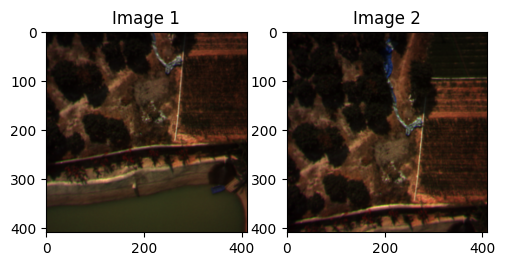

In [6]:
# load hyperspectral image and extract rgb image 

# hyperImage = load_hsi(hyperspectral_image1)  # between 0 and 255
# hyperImage2 = load_hsi(hyperspectral_image2)  #between 0 and 255

hyperImage = reprocessMeasurement(userSettingsDir,hyperspectral_image1,darkLoc,whiteLoc,distanceLoc,factoryDir)
hyperImage2 = reprocessMeasurement(userSettingsDir,hyperspectral_image2,darkLoc,whiteLoc,distanceLoc,factoryDir)



hyperImage_norm = (hyperImage/255).astype('float32') # between 0 and 1
hyperImage_norm2 = (hyperImage2/255).astype('float32') # between 0 and 1

num_layers = hyperImage.shape[0]

standard_array = load_array_from_url(STANDARD_ARRAY_URL)

example_image = extract_rgb(hyperImage)
example_image2 = extract_rgb(hyperImage2)


fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image)
plt.title('Image 1')

plt.subplot(1, 5, 2)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image2)
plt.title('Image 2')

plt.show()


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:45: UserWarning: xFormers is disabled (SwiGLU)
  warnings.warn("xFormers is disabled (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:29: UserWarning: xFormers is disabled (Attention)
  warnings.warn("xFormers is disabled (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:35: UserWarning: xFormers is disabled (Block)
  warnings.warn("xFormers is disabled (Block)")
/root/.cache/torch/hub/f

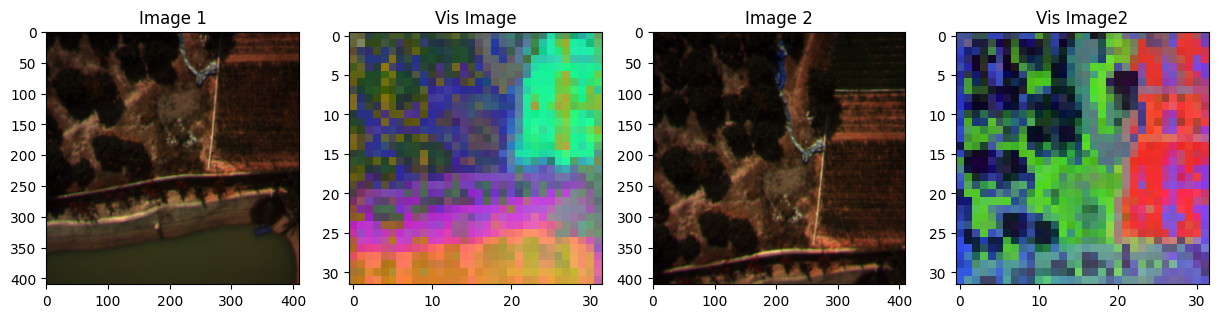

In [7]:
# create feature image from rgb images 


dm = Dinov2Matcher(half_precision=False)


# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(example_image)
features1 = dm.extract_features(image_tensor1)
# Visualization
vis_image = dm.get_embedding_visualization(features1, grid_size1)


image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(example_image2)
features2 = dm.extract_features(image_tensor2)
# Visualization
vis_image2 = dm.get_embedding_visualization(features2, grid_size2)


fig = plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image)
plt.title('Image 1')

plt.subplot(1, 4, 2)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image)
plt.title('Vis Image')

plt.subplot(1, 4, 3)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image2)
plt.title('Image 2')

plt.subplot(1, 4, 4)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image2)
plt.title('Vis Image2')

plt.show()



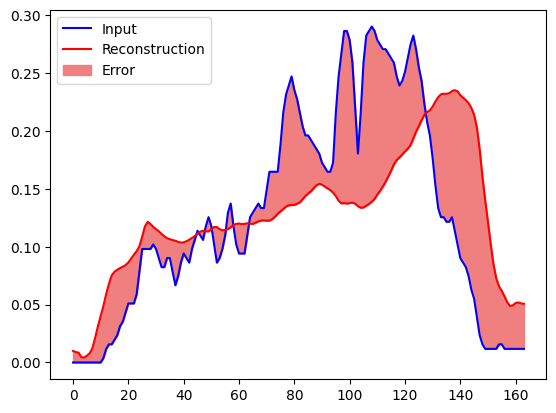

In [8]:
# run through auto encoder and look at rgb image 
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

spectral_model = spectral_AE()
spectral_model.load_state_dict(torch.load(autoencoder_file))
spectral_model.to(device)

#image 1 
new_shape_first_dim = hyperImage_norm.shape[1] * hyperImage_norm.shape[2]
hyperImage_reshaped = np.transpose(hyperImage_norm, (1, 2, 0))  # Reshape hyperImage before encoding
hyperImage_reshaped = hyperImage_reshaped.reshape((new_shape_first_dim, -1))  # Keep the second dimension flexible
# print(np.min(hyperImage_reshaped))
# print(np.max(hyperImage_reshaped))
# print(hyperImage_reshaped.shape)
# print(hyperImage.shape)

hyper_2d_tensor = torch.from_numpy(hyperImage_reshaped).float().to(device)
encoded_data = spectral_model.encoder(hyper_2d_tensor).detach().cpu().numpy()
encoded_data_reshaped = encoded_data.reshape(hyperImage.shape[1],hyperImage.shape[2],3)
decoded_data = spectral_model.decoder(torch.from_numpy(encoded_data).to(device)).detach().cpu().numpy()


#image 2
new_shape_first_dim2 = hyperImage_norm2.shape[1] * hyperImage_norm2.shape[2]
hyperImage_reshaped2 = np.transpose(hyperImage_norm2, (1, 2, 0))  # Reshape hyperImage before encoding
hyperImage_reshaped2 = hyperImage_reshaped2.reshape((new_shape_first_dim2, -1))  # Keep the second dimension flexible

hyper_2d_tensor2 = torch.from_numpy(hyperImage_reshaped2).float().to(device)
encoded_data2 = spectral_model.encoder(hyper_2d_tensor2).detach().cpu().numpy()
encoded_data_reshaped2 = encoded_data2.reshape(hyperImage2.shape[1],hyperImage2.shape[2],3)
decoded_data2 = spectral_model.decoder(torch.from_numpy(encoded_data2).to(device)).detach().cpu().numpy()



plt.plot(hyperImage_reshaped[test_index], 'b')
plt.plot(decoded_data[test_index], 'r')
plt.fill_between(np.arange(hyperImage_reshaped.shape[1]), decoded_data[test_index], hyperImage_reshaped[test_index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()



-87.93238 9.49404


<Figure size 1500x500 with 0 Axes>

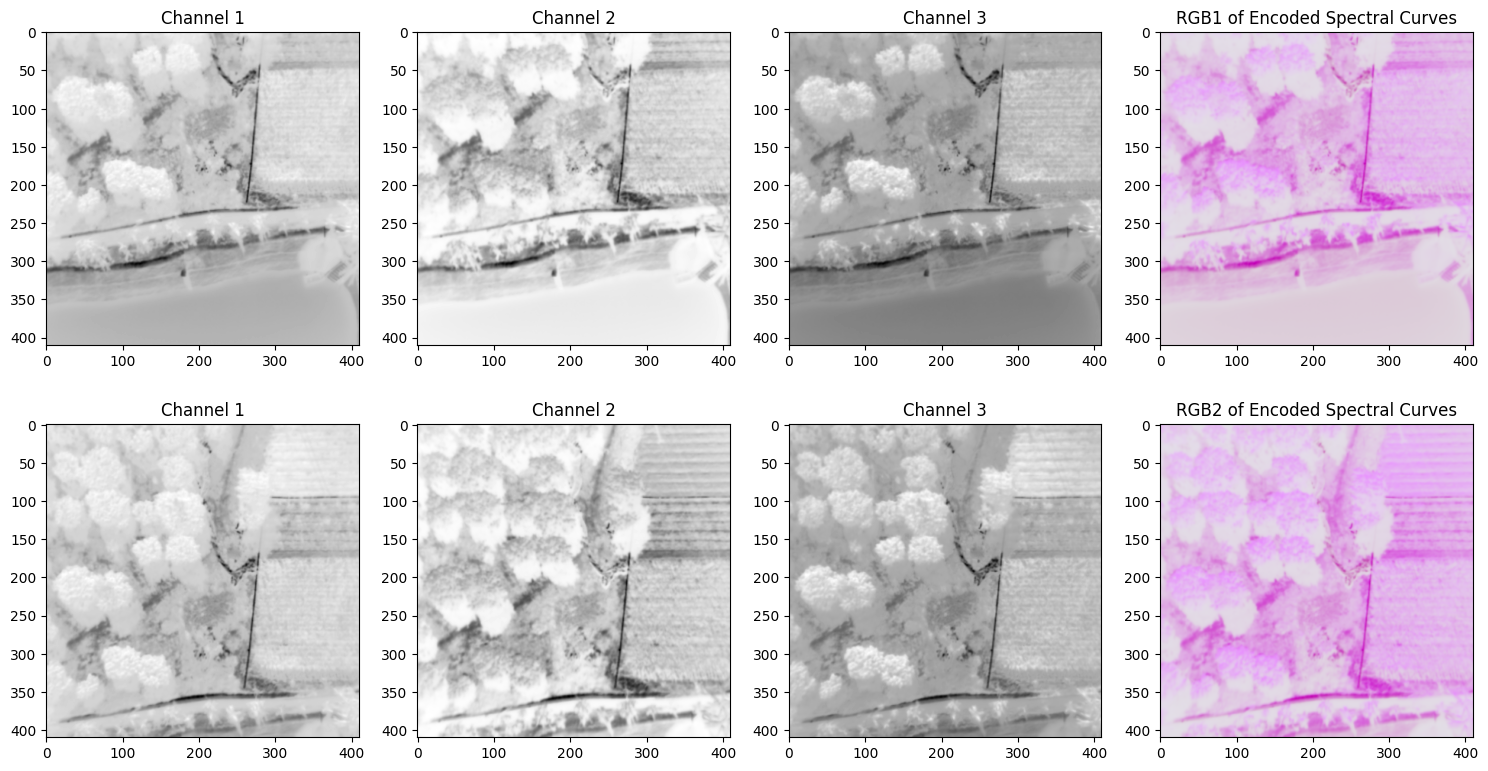

In [9]:
plt.figure(figsize=(15, 5))


# print(np.min(encoded_data_reshaped),np.min(encoded_data_reshaped2))
# print(np.max(encoded_data_reshaped),np.max(encoded_data_reshaped2))
combined_data = np.concatenate((encoded_data_reshaped.flatten(), encoded_data_reshaped2.flatten()))
# Print the minimum and maximum of the combined data
max_val = np.max(combined_data)
min_val = np.min(encoded_data_reshaped)
print(min_val, max_val)

encoded_data_reshaped_norm = encoded_data_reshaped - min_val
encoded_data_reshaped_norm = encoded_data_reshaped_norm/(max_val-min_val)

encoded_data_reshaped_norm2 = encoded_data_reshaped2 - min_val
encoded_data_reshaped_norm2 = encoded_data_reshaped_norm2/(max_val-min_val)


fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# First row
axs[0, 0].imshow(encoded_data_reshaped_norm[:,:,0], cmap='gray')
axs[0, 0].set_title('Channel 1')

axs[0, 1].imshow(encoded_data_reshaped_norm[:,:,1], cmap='gray')
axs[0, 1].set_title('Channel 2')

axs[0, 2].imshow(encoded_data_reshaped_norm[:,:,2], cmap='gray')
axs[0, 2].set_title('Channel 3')

axs[0, 3].imshow(encoded_data_reshaped_norm)
axs[0, 3].set_title('RGB1 of Encoded Spectral Curves')

# Second row
axs[1, 0].imshow(encoded_data_reshaped_norm2[:,:,0], cmap='gray')
axs[1, 0].set_title('Channel 1')

axs[1, 1].imshow(encoded_data_reshaped_norm2[:,:,1], cmap='gray')
axs[1, 1].set_title('Channel 2')

axs[1, 2].imshow(encoded_data_reshaped_norm2[:,:,2], cmap='gray')
axs[1, 2].set_title('Channel 3')

axs[1, 3].imshow(encoded_data_reshaped_norm2)
axs[1, 3].set_title('RGB2 of Encoded Spectral Curves')

plt.tight_layout()
plt.show()

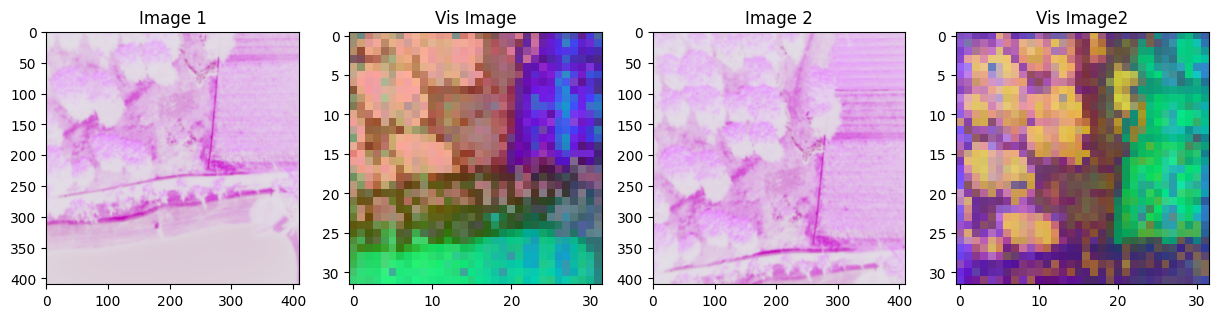

In [10]:
# Init Dinov2Matcher
# dm = Dinov2Matcher(half_precision=False)


image3=(encoded_data_reshaped_norm*255).astype('uint8')
image4=(encoded_data_reshaped_norm2*255).astype('uint8')



# # Extract features
image_tensor3, grid_size3, resize_scale3 = dm.prepare_image(image3)
features3 = dm.extract_features(image_tensor3)
# Visualization
vis_image3 = dm.get_embedding_visualization(features3, grid_size3)


image_tensor4, grid_size4, resize_scale4 = dm.prepare_image(image4)
features4 = dm.extract_features(image_tensor4)
# Visualization
vis_image4 = dm.get_embedding_visualization(features4, grid_size4)




fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(image3)
plt.title('Image 1')

plt.subplot(1, 4, 2)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image3)
plt.title('Vis Image')

plt.subplot(1, 4, 3)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(image4)
plt.title('Image 2')

plt.subplot(1, 4, 4)  # 1 row, 3 columns, 3rd subplot = vis_image
plt.imshow(vis_image4)
plt.title('Vis Image2')

# plt.subplot(1, 4, 2)  # 1 row, 3 columns, 2nd subplot = mask1
# plt.imshow(mask1)
# plt.title('Mask 1')

plt.show()

# More info
# print("features1.shape:", features1.shape)
# print("image1.shape:", image1.shape)
# print("mask1.shape:", mask1.shape)
# print("image_tensor1.shape:", image_tensor1.shape)
# print("grid_size1:", grid_size1)
# print("resize_scale1:", resize_scale1)

In [11]:
#custom patch matching code used for debugging and testing 


def make_foreground_mask_custom(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    
    
    projection = tokens @ standard_array_custom
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()



def make_transform_custom(smaller_edge_size: int) -> transforms.Compose:
    # reference values 
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    
    # IMAGENET_DEFAULT_MEAN = (0.2, 0.15, 0.1)
    # IMAGENET_DEFAULT_STD = (0.13, 0.1, 0.06)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])
    
    
    
def prepare_image_custom(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    
    transform = make_transform_custom(int(smaller_edge_size))
    # print(image.size)
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size



def render_patch_pca_custom(image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False) -> Image:
    
    
    image_tensor, grid_size = prepare_image_custom(image, smaller_edge_size, patch_size)
    
    
    #debug plot 
    # Transpose the image data
    image_data_transposed = np.transpose(image_tensor, (1, 2, 0))
    # Display the image
    # plt.imshow(image_data_transposed)



    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze()

    mask = make_foreground_mask_custom(tokens,
                                grid_size,
                                background_threshold,
                                apply_opening,
                                apply_closing)

    
    # print('here ', mask )
    print('pixels in mask for dense matching in yellow')
    plt.imshow(mask.reshape(grid_size))
    # plt.imshow(tokens)
    # plt.imshow(tokens[mask])

    
    pca = PCA(n_components=3)
    pca.fit(tokens[mask])
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    array[~mask] = 0
    array = array.reshape(*grid_size, 3)

    return Image.fromarray(array).resize((image.width, image.height), 0)




In [12]:
#generate feature patches for image 1
# this is not currently working  

example_image_pil = Image.fromarray(example_image)
example_image_pil2 = Image.fromarray(example_image2)
# display(example_image_pil)
# print(f"using {MODEL_NAME} model")
model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME)
model.eval()
# print(f"patch size: {model.patch_size}")

# EXAMPLE_IMAGE_URL = "../images/asd1.jpg"
# example_image__ref = Image.open(EXAMPLE_IMAGE_URL).convert("RGB")

# display(example_image_pil)

#to be used in make transform custom function 
# Calculate the mean and standard deviation of your dataset
# Convert the image to a numpy array
# example_image_np = np.array(example_image_pil)

# Calculate the mean and standard deviation of your image
# image_mean = np.mean(example_image_np, axis=(0, 1))
# image_std = np.std(example_image_np, axis=(0, 1))

# print('mean and std', image_mean, image_std)



# # Use these values to normalize your data
# transforms.Normalize(mean=dataset_mean, std=dataset_std)

# # Reshape the array to the correct shape
# standard_array_reshaped = standard_array.reshape(32, 24)
# print('max and min', np.max(standard_array_reshaped), np.min(standard_array_reshaped))

# # Display the image
# plt.imshow(standard_array_reshaped, cmap='gray')

standard_array_custom = standard_array


image3_result = render_patch_pca(image=example_image_pil,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=back_treshold_temp_rgb,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)

# display(image3_result)
# # display(example_image_pil)


# image4_result = image3_result
# run it all again for image 2
model.eval()
# print(f"patch size: {model.patch_size}")
image4_result = render_patch_pca(image=example_image_pil2,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=back_treshold_temp_rgb,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)
# display(image2_result)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


(410, 410)
(410, 410)


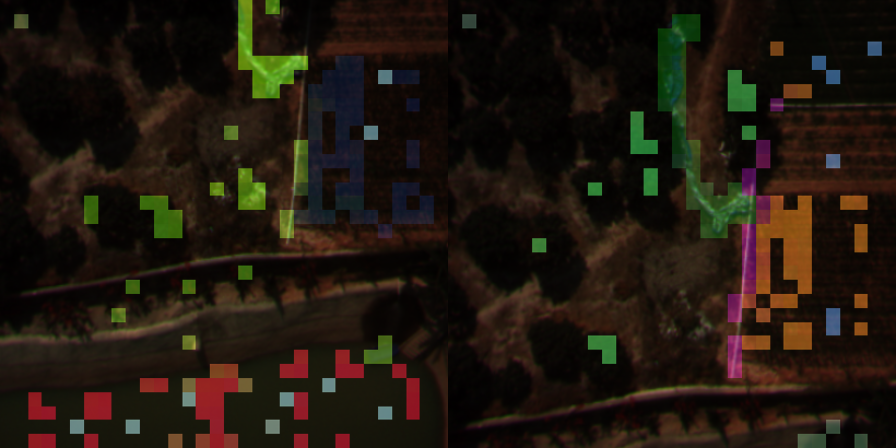

In [13]:
#display results

#resize images to same size
default_width = 448
default_height = 448
image3_result = image3_result.resize((default_width, default_height))
image4_result = image4_result.resize((default_width, default_height))

# display(image1_result)
# display(image2_result)


# Create a new image with width as the sum of both image widths and height as the maximum of image heights
new_image = Image.new('RGB', (default_width * 2, default_height))

# Paste the images into the new image
new_image.paste(image3_result, (0, 0))
new_image.paste(image4_result, (default_width, 0))

# Display the new image
# display(new_image)

#show the original images
# display(example_image)
new_image2 = Image.new('RGB', (default_width * 2, default_height))
example_image_pil = example_image_pil.resize((default_width, default_height))
example_image_pil2 = example_image_pil2.resize((default_width, default_height))
new_image2.paste(example_image_pil, (0, 0))
new_image2.paste(example_image_pil2, (default_width, 0))
# display(new_image2)



# Blend the images
alpha = 0.5  # Transparency factor

# The two images must be the same size
if new_image.size != new_image2.size:
    print("Images do not have the same size!")
else:
    blended = Image.blend(new_image, new_image2, alpha)

    # Display the blended image
    display(blended)


(410, 410)
(410, 410)


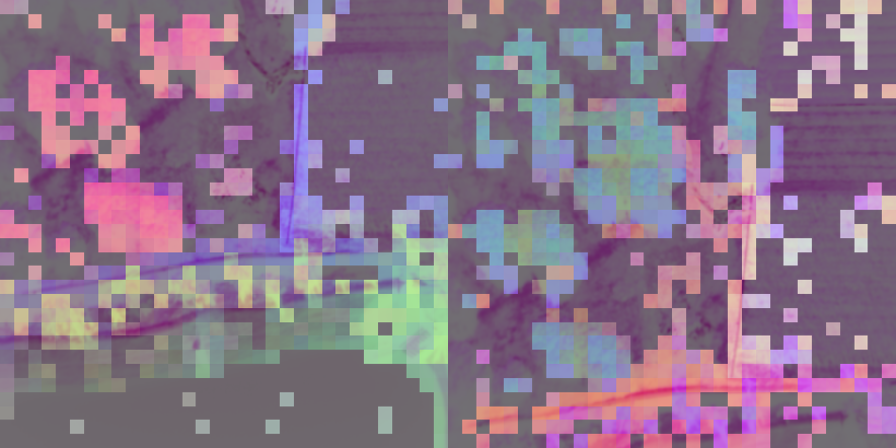

In [17]:
# repeat for the spectral images 

example_image_pil3 = Image.fromarray(image3)
example_image_pil4 = Image.fromarray(image4)

model.eval()
image5_result = render_patch_pca(image=example_image_pil3,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=back_treshold_temp_spectral,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)

model.eval()
image6_result = render_patch_pca(image=example_image_pil4,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=back_treshold_temp_spectral,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)




#display results
image5_result = image5_result.resize((default_width, default_height))
image6_result = image6_result.resize((default_width, default_height))
new_image = Image.new('RGB', (default_width * 2, default_height))
new_image.paste(image5_result, (0, 0))
new_image.paste(image6_result, (default_width, 0))
new_image2 = Image.new('RGB', (default_width * 2, default_height))
example_image_pil3 = example_image_pil3.resize((default_width, default_height))
example_image_pil4 = example_image_pil4.resize((default_width, default_height))
new_image2.paste(example_image_pil3, (0, 0))
new_image2.paste(example_image_pil4, (default_width, 0))
alpha = 0.5  # Transparency factor

# The two images must be the same size
if new_image.size != new_image2.size:
    print("Images do not have the same size!")
else:
    blended = Image.blend(new_image, new_image2, alpha)

    # Display the blended image
    display(blended)
